## Предобработка изображений

Чтобы подготовить изображения для дальнейшего использования их в модели, выполним следующие операции:

- сделаем картинку черно-белой
- применим гауссовское сглаживание
- уменьшим размер до 64 * 64
- сегментируем (отделим объект от фона с помощью адаптивного порога)

### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import os
import random
import cv2
from scipy.linalg import svd
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import hog
from skimage.exposure import rescale_intensity

import pandas as pd

In [5]:
dir = './Dataset'

In [6]:
# создадим датафрем с нашими данными.

name = []
for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
      name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])

df = pd.DataFrame(columns = ['category', 'way'], data = name)
df.shape

(216, 2)

In [7]:
# заменим категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
  slovar[value] = counter

df['category'] = df['category'].map(slovar)

In [8]:
df.head()

,category,way
0,0,./Dataset/fork/IMG_20211122_105752_color.jpg
1,0,./Dataset/fork/IMG_20211118_154748_color.jpg
2,0,./Dataset/fork/IMG_20211119_084920_color.jpg
3,0,./Dataset/fork/IMG_20211122_105752_vflip.jpg
4,0,./Dataset/fork/IMG_20211120_173901_rot.jpg


In [9]:
df['category'].value_counts()

3    56
1    48
5    40
2    28
4    24
0    20
Name: category, dtype: int64

Попробуем предобработать одно из изображений

Посмотрим на него (будем использовать ч/б вариант изображения)

Shape of source image (3000, 4000)


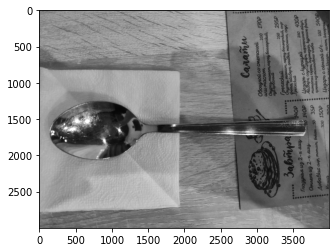

In [11]:
file_name = "./Dataset/spoon/IMG_20211117_083555.jpg"

img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

print(f"Shape of source image {img.shape}")
plt.imshow(img, cmap="gray")


Затем применим фильтр Гаусса для сглаживания, вырежем квадратный фрагмент и уменьшим его

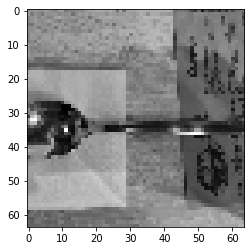

In [12]:
# размытие (сглаживание)
img = cv2.GaussianBlur(img, (15, 15), 3)

# вырежем из изображения случайный квардратный фрагмент
img_h, img_w = img.shape
bias = random.randint(0, img_w - img_h)
img = img[:, bias : bias + img_h]  

# уменьшим размер
img = cv2.resize(img, (64, 64))

# нормализуем интенсивности от 0 до 255
img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)

plt.imshow(img, cmap="gray")

Теперь попробуем применить различные методы сегментации:
- с глобальным порогом, одинаковым для всего изображения (порог возьмем по-середине, т.е. в интенсивности 127)
- с адаптивным порогом (среднее)
- с адаптивным порогом (гауссиан)

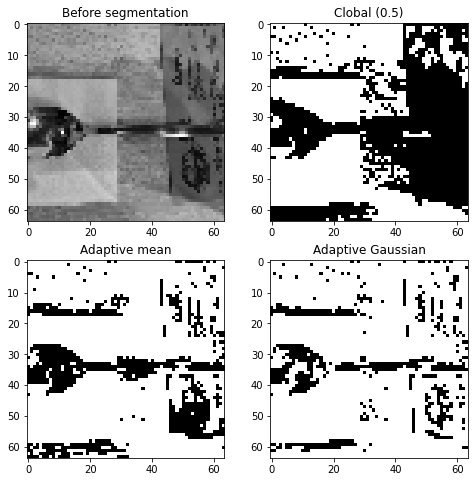

In [13]:
# cегментация с глобальным порогом (общим для всего изображения)
ret, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# сегментация с адаптивным порогом
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 24)

th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 24)

images = [img, th1, th2, th3]
titles = ['Before segmentation', 'Clobal (0.5)', 'Adaptive mean', 'Adaptive Gaussian']

fig = plt.figure(figsize=(8, 8))
for i in range(4):
  plt.subplot(2, 2, i + 1)
  plt.imshow(images[i], cmap='gray')
  plt.title(titles[i])


Видно, что адаптивные методы работают лучше. Особенно это заметно на изображениях с неровным освещением. 

Пока что выберем метод адаптации порога с помощью среднего. Посмотрим еще на нескольких изображениях, что получается в результате такой предобработки:

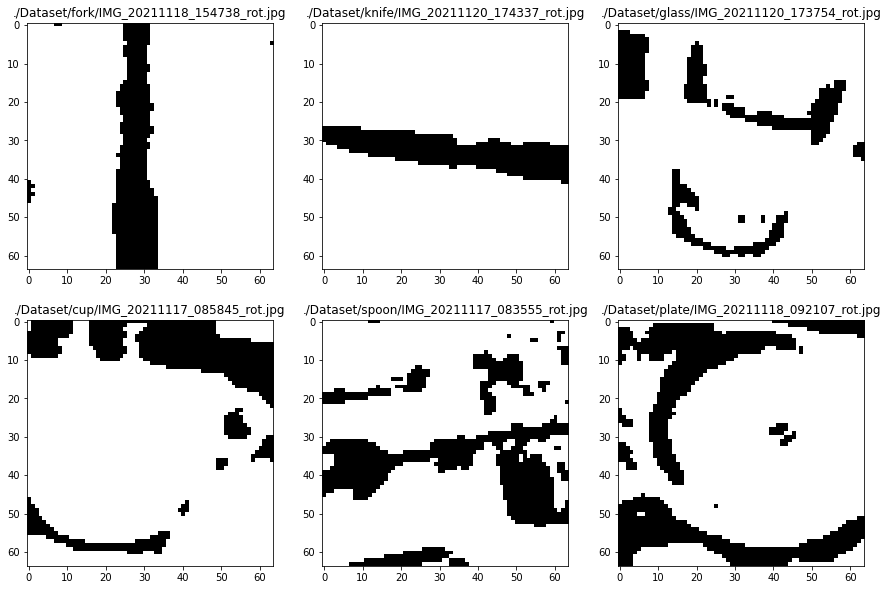

In [15]:
def prepare(image):
    img = image

    # размытие (сглаживание)
    img = cv2.GaussianBlur(img, (15, 15), 3)

    # вырежем из изображения случайный квардратный фрагмент
    img_h, img_w = img.shape
    bias = random.randint(0, abs(img_w - img_h)) 
    img = img[:, bias : bias + img_h] if img_h < img_w else img[bias : bias + img_w, :]

    # уменьшим размер
    img = cv2.resize(img, (64, 64))

    # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)

    # сегментация с адаптивным порогом (среднее)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 16)

    # уберем шум с помощью медианного фильтра
    img = cv2.medianBlur(img, 3)

    return img


file_list = ["./Dataset/fork/IMG_20211118_154738_rot.jpg","./Dataset/knife/IMG_20211120_174337_rot.jpg", 
             "./Dataset/glass/IMG_20211120_173754_rot.jpg", "./Dataset/cup/IMG_20211117_085845_rot.jpg",
             "./Dataset/spoon/IMG_20211117_083555_rot.jpg", "./Dataset/plate/IMG_20211118_092107_rot.jpg"]

images = []
titles = []

for f in file_list:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    prepared_img = prepare(img)
    images.append(prepared_img)
    titles.append(f)

fig = plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

На всех картинках объект угадывается.

Я думаю, можно попробовать:
- вычислить отношение ширины и длины объекта (это поможет отделить вытянутые формы от круглых или квадратных) - это реализовано ниже, на незашумленных изображениях дает хороший результат
- поискать углы (особые точки)
- гистограммы градиентов

# Feature extraction


Text(0.5, 1.0, 'Histogram of Oriented Gradients')

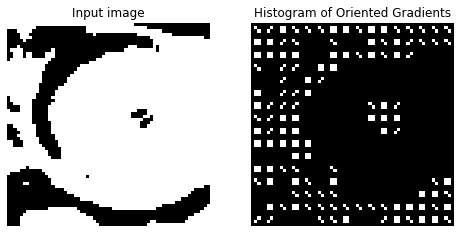

In [16]:
fd, hog_image = hog(images[5], orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(images[5], cmap='gray')
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('Histogram of Oriented Gradients')

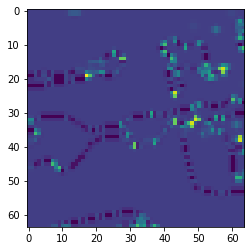

In [17]:
dst = cv2.cornerHarris(images[4],2,3,0.04)

plt.imshow(dst)

In [18]:
# Определение соотношения длины и ширины объекта

def height_wight_rate(image):
    # для вычисления нужен сегментированный файл с бинарной картинкой c белым фоном и черным объектом (?)

    # возвращает 1 - вектор доминирующего направления, 
    # 2 - отношение размеров объекта (min/max, если около 0 - объект вытянутой формы, около 1 - круглой/квадратной)

    # Соберем все черные точки изображения в массив xy
    xy = None
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
              if not image[i, j]:
                if xy is None:
                    xy = np.array([[j, i]])
                else:
                    xy = np.append(xy,[[j, i]], axis=0)

    # # вычтем из х и у средние значения
    # m = (xy[:, 0].mean(), xy[:, 1].mean())
    # xy -= m

    # Вычислим матрицу ковариации x и y
    covmatrix = np.cov(xy.T)

    # выполним SVD разложение матрицы для определения доминирующего направления и размеров объекта
    U, D, V_T = svd(covmatrix)

    return U[:, 0], D[1] / D[0]


dominant_vect, h_w_rate = height_wight_rate(th3)
print("Доминирующее направление", dominant_vect)
print("\nОтношение размеров объекта (min/max, если около 0 - объект вытянутой формы, около 1 - круглой/квадратной)\n", h_w_rate)


Доминирующее направление [-0.99844476  0.05575005]

Отношение размеров объекта (min/max, если около 0 - объект вытянутой формы, около 1 - круглой/квадратной)
 0.5634380527470709


In [19]:
def get_h_w_rate(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    img = prepare(img)

    _, h_w_rate = height_wight_rate(img)
    return h_w_rate

def mean_intens(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    img = prepare(img)
    return np.mean(img)

df["h_w_rate"] = df["way"].apply(get_h_w_rate)
df["mean"] = df["way"].apply(mean_intens)

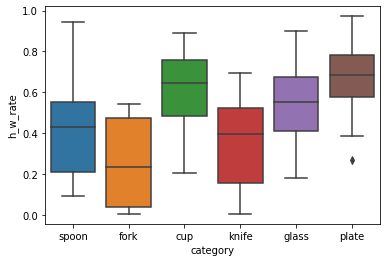

In [ ]:
import seaborn as sns

sns.boxplot(y="h_w_rate", x="category", data=df)

Для вилок, ложек и ножей отношение длины к ширине в среднем ниже, чем для стаканов, тарелок и чашек. Если удастся лучше выделить объект, то зависимость должна быть более четкой

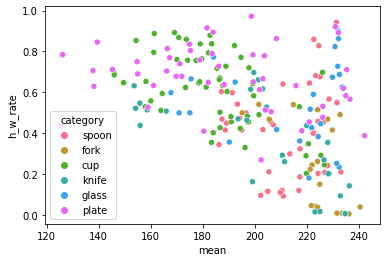

In [ ]:
sns.scatterplot(x="mean", y="h_w_rate", hue="category", data=df, palette="husl")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
scores = cross_val_score(knn, df[["h_w_rate", "mean"]], df["category"], cv=5, scoring='accuracy')

scores


array([0.45454545, 0.34883721, 0.34883721, 0.30232558, 0.25581395])

In [ ]:
print("Доля самого многочисленного класса в выборке", round(max(df["category"].value_counts()) / df["category"].shape[0], 2))

Доля самого многочисленного класса в выборке 0.26


## XGBOOST

Прогоним все фотки через  prepare, нереведем в массив 

In [20]:
def prepared(image):
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # размытие (сглаживание)
    img = cv2.GaussianBlur(img, (15, 15), 3)



    # уменьшим размер
    img = cv2.resize(img, (15, 15))

    # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)

    # сегментация с адаптивным порогом (среднее)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 16)

    # уберем шум с помощью медианного фильтра
    img = cv2.medianBlur(img, 3)

    #переведем данные в значения от 0 до 1
    img = img/255

    # return np.resize(img,(1,225))
    return img.reshape(1, 225)



In [21]:
from sklearn.model_selection import train_test_split

new = df['way'].apply(prepared) # преобразования
X = np.concatenate(new).astype(None) # объединяем в массив
y = df['category']

#делим на трейн и тест
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [22]:
X_train.shape , X_val.shape

# получае 183 в трейне и 33 на валидации

((183, 225), (33, 225))

In [25]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgboost = XGBClassifier(learning_rate =0.05,
 n_estimators=25,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(X_train, y_train)

/home/tanya/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:56] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
print('Cross Validation for XGBClassifier')
print(xgboost.score(X_val, y_val))

Cross Validation for XGBClassifier
0.696969696969697


In [27]:
# посмотрим на качество предсказаний по каждой категории

predict = xgboost.predict(X_val)
test_result = pd.DataFrame(data = np.array([y_val, predict]).T,
                           columns = ["y_true", "y_predict"])
test_result["match"] = (test_result["y_true"] == test_result["y_predict"])
test_result.groupby("y_true")["match"].mean()

y_true
0    0.500000
1    1.000000
2    1.000000
3    0.750000
4    1.000000
5    0.333333
Name: match, dtype: float64

In [28]:
# посмотрим, с чем модель путает вилки
test_result.loc[test_result["y_true"] == 5]

,y_true,y_predict,match
0,5,5,True
1,5,4,False
3,5,2,False
6,5,2,False
8,5,1,False
12,5,2,False
15,5,1,False
20,5,5,True
29,5,5,True


In [ ]:
slovar

{'cup': 1, 'fork': 5, 'glass': 3, 'knife': 4, 'plate': 0, 'spoon': 2}

## Каскады HOG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -qq /content/drive/MyDrive/учеба/ВЫШКА/НИС/Dataset-20211123T142557Z-001.zip

In [ ]:
#обновим данные
name = []
for dirname, _, filenames in os.walk('/content/Dataset'):
    for filename in filenames:
      name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])

df = pd.DataFrame(columns = ['category', 'way'], data = name)
df.head()

# заменить категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
  slovar[value] = counter

df['category'] = df['category'].map(slovar)

#Попробуем преобразовать наши изображения в помощью adaptiveThreshold а получить вектор из каскадов HOG

winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

def vektors(img_n):
  img = cv2.imread(img_n, cv2.IMREAD_GRAYSCALE)
  img_Threshold = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7)
  hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                          histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
  
  winStride = (8,8)
  padding = (8,8)
  locations = ((10,20),)
  hist = hog.compute(img_Threshold,winStride,padding,locations) # получаем вектор признаков
  return hist.T


new_df = pd.DataFrame(columns=['category', 'vector'])
new_df['category'] = df['category']
new_df['vector'] = df['way'].apply(vektors)

In [ ]:
new_df